# Purpose:
- Generate a uniform sample subset for evaluation
- Uniform quantities of levels for each engagement level
- Equal number of samples for males and femalse
- Samples are selected at random

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from tqdm import tqdm

import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.

from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Model, Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

from keras.applications import xception
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# File handling imports
import shutil

In [2]:
labels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Males'), header=None)

females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

# Add gender feature columns
labels['male'] = labels.apply(lambda x: x['ClipID'] in males_list, axis=1)
labels['female'] = labels.apply(lambda x: x['ClipID'] in females_list, axis=1)

In [3]:
valLabels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'ValidationLabels.csv'))

In [4]:
missing = len(set(valLabels['ClipID'].values.tolist()) - set(labels['ClipID'].values.tolist()))
print(f'There are {missing} samples without labels!')

There are 0 samples without labels!


In [5]:
labels['ID_num'] = labels['ClipID'].str[:-4]
# we want to make sure that there is a binary constraint
assert labels.loc[labels['male']!=labels['female']].shape == labels.shape

# Create a single column for gender
labels['gender'] = labels.apply(lambda x: 1 if x['ClipID'] in males_list else 0, axis=1)

labels.drop(['male', 'female'], axis=1, inplace=True)
labels.drop(['Boredom', 'Confusion', 'Frustration '], axis=1, inplace=True)

labels['ID'] = labels['ClipID'].str[:-4]
labels['ID'] = pd.to_numeric(labels['ID'])

In [6]:
labels.head()

,ClipID,Engagement,ID_num,gender,ID
0,1100011002.avi,2,1100011002,1,1100011002
1,1100011003.avi,2,1100011003,1,1100011003
2,1100011004.avi,3,1100011004,1,1100011004
3,1100011005.avi,3,1100011005,1,1100011005
4,1100011006.avi,3,1100011006,1,1100011006


In [7]:
labels_ohe = pd.get_dummies(labels.Engagement)

In [8]:
labels_ohe.head()

,0,1,2,3
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [9]:
labels_ohe['array'] = labels_ohe.apply(lambda x: np.array([x[0], x[1], x[2], x[3]]), axis=1)

In [10]:
labels = labels.join(labels_ohe)

In [11]:
#labels.drop(['Engagement'], axis=1, inplace=True)
labels.drop(['ClipID'], axis=1, inplace=True)

In [12]:
labels.head()

,Engagement,ID_num,gender,ID,0,1,2,3,array
0,2,1100011002,1,1100011002,0,0,1,0,"[0, 0, 1, 0]"
1,2,1100011003,1,1100011003,0,0,1,0,"[0, 0, 1, 0]"
2,3,1100011004,1,1100011004,0,0,0,1,"[0, 0, 0, 1]"
3,3,1100011005,1,1100011005,0,0,0,1,"[0, 0, 0, 1]"
4,3,1100011006,1,1100011006,0,0,0,1,"[0, 0, 0, 1]"


# Build Validation DataFrame

In [13]:
val_path = 'dataset/Validation/'

print("building validation set")
missing_count = 0
val_set = []
for filename in tqdm(os.listdir(val_path)):
    try:
        sample_ID = filename[:filename.index('-')]
        #engagement = labels[labels['ID_num']==sample_ID].values.tolist()[0][1:-1]
        #gender = labels[labels['ID_num']==sample_ID].values.tolist()[1]
        row = labels[labels['ID_num']==sample_ID]
        engagement = row['Engagement'].values[0]
        tensor = row['array'].values[0]
        gender = row['gender'].values[0]
        val_set.append([filename, engagement, gender,
                        row[0].values[0],
                        row[1].values[0],
                        row[2].values[0],
                        row[3].values[0],
                        row['ID'].values[0],
                        tensor])
    except IndexError:
        missing_count += 1
print(f'There are {missing_count} samples without labels!')

building validation set


100%|██████████████████████████████████████████████████████████████████████████| 12039/12039 [00:10<00:00, 1153.03it/s]

There are 0 samples without labels!


In [14]:
val_df = pd.DataFrame(val_set, columns=['filename', 'Engagement', 'gender',0,1,2,3,'ID', 'array'])

In [15]:
val_df.head()

,filename,Engagement,gender,0,1,2,3,ID,array
0,4000221001-1.jpg,2,1,0,0,1,0,4000221001,"[0, 0, 1, 0]"
1,4000221001-2.jpg,2,1,0,0,1,0,4000221001,"[0, 0, 1, 0]"
2,4000221001-3.jpg,2,1,0,0,1,0,4000221001,"[0, 0, 1, 0]"
3,4000221001-4.jpg,2,1,0,0,1,0,4000221001,"[0, 0, 1, 0]"
4,4000221001-5.jpg,2,1,0,0,1,0,4000221001,"[0, 0, 1, 0]"


# Determine N

In [16]:
val_df.loc[(val_df[0]==1) & (val_df['gender']==0)].shape[0]

21

In [17]:
lowest_qty = np.inf

for gender in [0, 1]:
    for level in [0, 1, 2, 3]:
        size = val_df.loc[(val_df['Engagement']==level) & (val_df['gender']==gender)].shape[0]
        if size < lowest_qty: lowest_qty = size
        print(f'The number of samples of gender {gender} and engagement {level}: {size}')

print(f'The lowest sample qty is {lowest_qty}')

The number of samples of gender 0 and engagement 0: 21
The number of samples of gender 0 and engagement 1: 252
The number of samples of gender 0 and engagement 2: 1309
The number of samples of gender 0 and engagement 3: 2141
The number of samples of gender 1 and engagement 0: 140
The number of samples of gender 1 and engagement 1: 868
The number of samples of gender 1 and engagement 2: 5075
The number of samples of gender 1 and engagement 3: 2233
The lowest sample qty is 21


In [18]:
uniform_df = pd.DataFrame()

for gender in [0, 1]:
    for level in [0, 1, 2, 3]:
        subset = val_df.loc[(val_df['Engagement']==level) & (val_df['gender']==gender)].sample(n=lowest_qty)
        uniform_df = pd.concat((uniform_df, subset))

In [19]:
uniform_df.head()

,filename,Engagement,gender,0,1,2,3,ID,array
9321,5674960225-5.jpg,0,0,1,0,0,0,5674960225,"[1, 0, 0, 0]"
9320,5674960225-4.jpg,0,0,1,0,0,0,5674960225,"[1, 0, 0, 0]"
9317,5674960225-1.jpg,0,0,1,0,0,0,5674960225,"[1, 0, 0, 0]"
9532,5674960283-6.jpg,0,0,1,0,0,0,5674960283,"[1, 0, 0, 0]"
8375,5564630126-4.jpg,0,0,1,0,0,0,5564630126,"[1, 0, 0, 0]"


In [20]:
uniform_df['Engagement'].describe()

count    168.000000
mean       1.500000
std        1.121376
min        0.000000
25%        0.750000
50%        1.500000
75%        2.250000
max        3.000000
Name: Engagement, dtype: float64

In [21]:
uniform_df['gender'].describe()

count    168.000000
mean       0.500000
std        0.501495
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: gender, dtype: float64

# Display some samples

In [22]:
# Import libraries
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from PIL import Image

In [23]:
sample_df = uniform_df.sample(n=10)
samples = sample_df['filename'].values
labels = sample_df['Engagement'].values

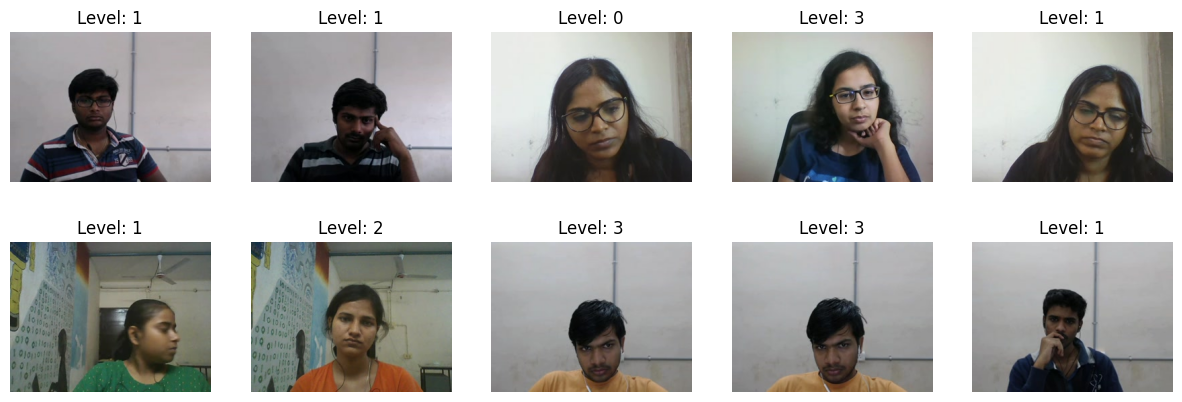

In [24]:
images = []
for sample in samples:
    img = Image.open(os.path.join(val_path, sample))
    img = np.array(img)
    images.append(img)
    
fig = plt.figure(figsize=(15, 5))
rows = 2
columns = 5

for index, (sample, label) in enumerate(zip(images,labels)):
    fig.add_subplot(rows, columns, index+1)
    plt.imshow(sample, cmap='gray')
    plt.axis('off')
    plt.title(f'Level: {label}')

# Run predictions on both models

In [25]:
filename = 'DAiSEE-AOR-model_1.h5'

def orthogonal_loss(y_true, y_pred, alpha=1):
    loss_categorical = keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss_categorical

model = load_model(filename, custom_objects={'orthogonal_loss':orthogonal_loss})

In [26]:
# Note: Tensors are of shape [batch, height, width, channels]


In [27]:
def prepare_sample_AOR(sample, face_only=False):
    
    img_height = 224
    img_width = 299

    preprocessed = tf.keras.applications.xception.preprocess_input(sample)
    
    resized = tf.image.resize(
        images=preprocessed,
        size=[img_height, img_width],
        method=tf.image.ResizeMethod.BILINEAR
    )
    
    reshaped = tf.reshape(resized, [1, img_height, img_width, 3])
    
    return reshaped

In [28]:
uniform_df.head()

,filename,Engagement,gender,0,1,2,3,ID,array
9321,5674960225-5.jpg,0,0,1,0,0,0,5674960225,"[1, 0, 0, 0]"
9320,5674960225-4.jpg,0,0,1,0,0,0,5674960225,"[1, 0, 0, 0]"
9317,5674960225-1.jpg,0,0,1,0,0,0,5674960225,"[1, 0, 0, 0]"
9532,5674960283-6.jpg,0,0,1,0,0,0,5674960283,"[1, 0, 0, 0]"
8375,5564630126-4.jpg,0,0,1,0,0,0,5564630126,"[1, 0, 0, 0]"


In [29]:
from matplotlib import image

results_AOR = []

filenames = uniform_df['filename'].values

for filename in tqdm(filenames):
    # Prepare single image
    img_path = os.path.join(val_path, filename)
    img = image.imread(img_path)
    img_array = prepare_sample_AOR(img)

    # Predict with model
    preds = model.predict(img_array, steps=1, verbose=0)
    
    # Compose result entry
    sample_ID = filename[:filename.index('-')]
    y_actual = uniform_df[uniform_df['ID']==int(sample_ID)]['Engagement'].values[0]
    gender = uniform_df[uniform_df['ID']==int(sample_ID)]['gender'].values[0]

    # Append to results
    results_AOR.append((np.argmax(preds[0], axis=1)[0], y_actual, gender))

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:15<00:00, 10.58it/s]


In [30]:
result_AOR_df = pd.DataFrame(results_AOR, columns = ['y_pred','y_true','gender'])

In [31]:
result_AOR_df

,y_pred,y_true,gender
0,2,0,0
1,2,0,0
2,2,0,0
3,2,0,0
4,3,0,0
...,...,...,...
163,2,3,1
164,2,3,1
165,2,3,1
166,2,3,1


In [32]:
from sklearn.metrics import classification_report

# AOR Classification Report

In [33]:
#labels = ['Very Low Engagement', 'Low Engagement', 'High Engagement', 'Very High Engagement']
labels = ['0: Very Low', '1: Low', '2: High', '3: Very High']
report = classification_report(result_AOR_df['y_true'], result_AOR_df['y_pred'], target_names=labels, zero_division=0) 
print(report)

              precision    recall  f1-score   support

 0: Very Low       0.00      0.00      0.00        42
      1: Low       0.33      0.02      0.04        42
     2: High       0.24      0.69      0.35        42
3: Very High       0.31      0.31      0.31        42

    accuracy                           0.26       168
   macro avg       0.22      0.26      0.18       168
weighted avg       0.22      0.26      0.18       168



In [34]:
report = classification_report(result_AOR_df['y_true'], result_AOR_df['y_pred'], target_names=labels, zero_division=0, output_dict=True) 
print(report)

{'0: Very Low': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 42}, '1: Low': {'precision': 0.3333333333333333, 'recall': 0.023809523809523808, 'f1-score': 0.044444444444444446, 'support': 42}, '2: High': {'precision': 0.23577235772357724, 'recall': 0.6904761904761905, 'f1-score': 0.3515151515151515, 'support': 42}, '3: Very High': {'precision': 0.30952380952380953, 'recall': 0.30952380952380953, 'f1-score': 0.30952380952380953, 'support': 42}, 'accuracy': 0.25595238095238093, 'macro avg': {'precision': 0.21965737514518002, 'recall': 0.25595238095238093, 'f1-score': 0.17637085137085137, 'support': 168}, 'weighted avg': {'precision': 0.21965737514518005, 'recall': 0.25595238095238093, 'f1-score': 0.17637085137085137, 'support': 168}}


# Predictions with the original model

In [35]:
print("Loading the DaiSEE model...")
model_dir = "Analytics/"
#model_name = 'Xception_on_DAiSEE.h5'
model_name = 'Xception_on_DAiSEE_finetune_fc.h5'
ER_model = load_model(os.path.join(model_dir, model_name))

Loading the DaiSEE model...


In [36]:
def prepare_sample(sample, face_only=False):

    preprocessed = tf.keras.applications.xception.preprocess_input(sample)
    
    resized = tf.image.resize(
        images=preprocessed,
        size=[299, 299],
        method=tf.image.ResizeMethod.BILINEAR
    )
    
    reshaped = tf.reshape(resized, [1, 299, 299, 3])
    
    return reshaped

In [37]:
results_original = []
for filename in tqdm(filenames):

    img_path = os.path.join(val_path, filename)
    img = image.imread(img_path)
    img_array = prepare_sample(img)

    # Predict
    preds = ER_model.predict(img_array, steps=1, verbose=0)
    sample_ID = filename[:filename.index('-')]
    
    y_actual = uniform_df[uniform_df['ID']==int(sample_ID)]['Engagement'].values[0]
    gender = uniform_df[uniform_df['ID']==int(sample_ID)]['gender'].values[0]

    results_original.append((np.argmax(preds[1]), y_actual, gender))

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:12<00:00, 13.61it/s]


In [38]:
results_original_df = pd.DataFrame(results_original, columns = ['y_pred','y_true','gender'])

# Original Classification Report

In [39]:
#labels = ['Very Low Engagement', 'Low Engagement', 'High Engagement', 'Very High Engagement']
labels = ['0: Very Low', '1: Low', '2: High', '3: Very High']
report = classification_report(results_original_df['y_true'], results_original_df['y_pred'], target_names=labels, zero_division=0) 
print(report)

              precision    recall  f1-score   support

 0: Very Low       0.00      0.00      0.00        42
      1: Low       0.00      0.00      0.00        42
     2: High       0.21      0.55      0.30        42
3: Very High       0.24      0.33      0.28        42

    accuracy                           0.22       168
   macro avg       0.11      0.22      0.15       168
weighted avg       0.11      0.22      0.15       168



# gender difference

In [40]:
male_results_original = results_original_df[results_original_df['gender']==1]
female_results_original = results_original_df[results_original_df['gender']==0]

In [41]:
def show_predictions(df, subset='', distribution=''):
    label_list = ['0: Very Low', '1: Low', '2: High', '3: Very High']
    
    count_list = [0, 0, 0, 0]
    for pred in df['y_pred'].value_counts().keys():
        count_list[pred] = df['y_pred'].value_counts()[pred] / sum(df['y_pred'].value_counts())

    plt.title(f'{subset} Subset Predictions of {distribution} Set')
    plt.bar([0,1,2,3], count_list, width=0.8, tick_label=label_list)
    for idx, value in enumerate(count_list):
        plt.text(idx, value+0.01, round(value, 2))

    plt.ylim([0, 1])
    plt.xlabel('Engagement Level')
    plt.ylabel('Proportion of Predictions')    

    plt.show

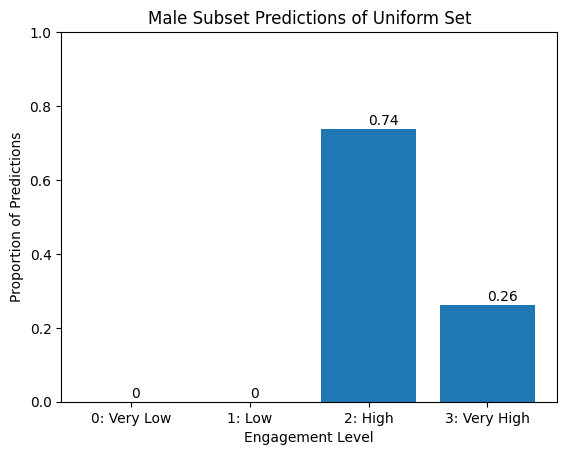

In [42]:
show_predictions(male_results_original, subset='Male', distribution='Uniform')

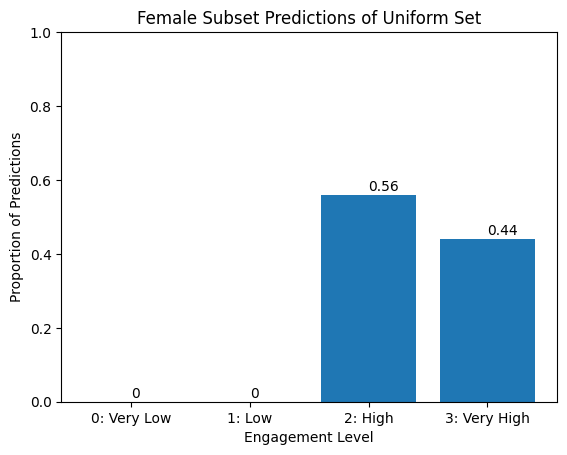

In [43]:
show_predictions(female_results_original, subset='Female', distribution='Uniform')

In [44]:
male_results_AOR = result_AOR_df[result_AOR_df['gender']==1]
female_results_AOR = result_AOR_df[result_AOR_df['gender']==0]

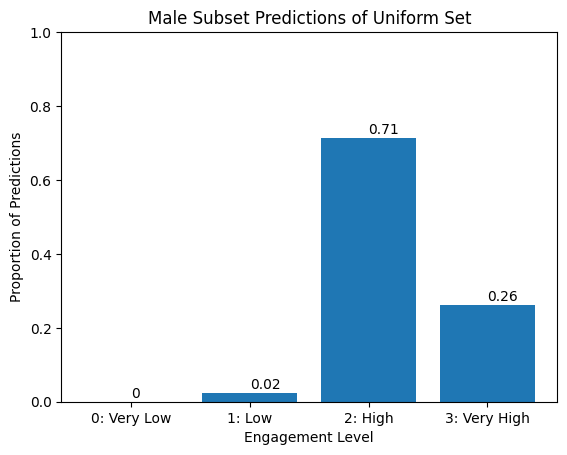

In [45]:
show_predictions(male_results_AOR, subset='Male', distribution='Uniform')

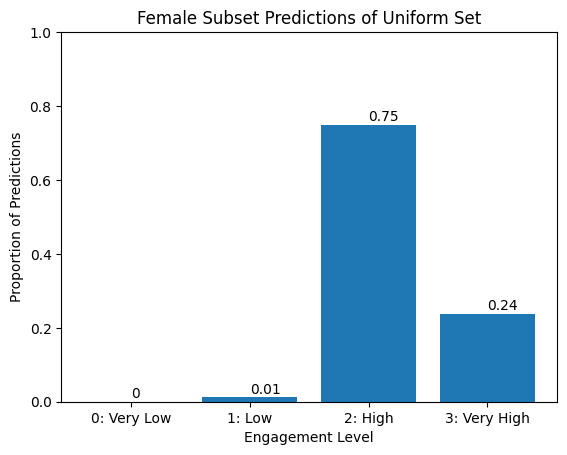

In [46]:
show_predictions(female_results_AOR, subset='Female', distribution='Uniform')